In [53]:
from math import floor
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
import numpy as np
import common # type: ignore
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

SEC_PER_SLOT = 12 * 60 * 60
EPS_TH = 0.5
DATASET = "CTU-13"
database = common.Database()
dataset = common.Dataset()
slot = common.Slot(database, SEC_PER_SLOT, EPS_TH, DATASET)


In [2]:
times_s = database.conn.execute(text(f"""
SELECT MAX(M.TIME_S) TIME_S,  MAX(M.TIME_S_TRANSLATED) TIME_S_TRANSLATED
FROM MESSAGE M JOIN PCAP ON M.PCAP_ID = PCAP.ID
WHERE PCAP.DATASET = '{DATASET}'""")).all()[0]._mapping

times_s

{'time_s': 1493733000.0, 'time_s_translated': 6135434.0}

In [4]:

display(Markdown("# Così è fuorviante perché le stesse request vengono contate in più slots."))
display(Markdown("Devo usare PGADMIN ed effettuare il calcolo per ogni slot attraverso messages."))
display(Markdown("Devo stare attento a selezionare solo i PCAP scelti."))
display(Markdown("Posso usare la stessa formula SQL di windowing solo che devo tradurla con i tempi."))
display(Markdown("O forse devo tradurre tutto coi tempi dopo? :O"))

display(Markdown("# Slots"))

display(Markdown("The number of requests over time have been calculated dividing the timeline in the so called slots.The slot value chosen is of 3600 seconds."))

display(Markdown("\n".join([
    "## Timestamp translation",
    "Since that we have different source, captured in different times, and we want to simulate a SOC receiving alarms, we set the "
    "starting moment of each source to 0 s, translating all the requests accordingly:"
])))

times_s = database.conn.execute(text(f"""
SELECT MAX(M.TIME_S) TIME_S,  MAX(M.TIME_S_TRANSLATED) TIME_S_TRANSLATED
FROM MESSAGE M JOIN PCAP ON M.PCAP_ID = PCAP.ID
WHERE PCAP.DATASET = '{DATASET}'""")).all()[0]._mapping

display(Markdown("\n".join([
    "- The last request timestamp is: %s (%s days)." % (times_s["time_s"], math.floor(times_s["time_s"] / dataset.DAY_SEC)),
    "- The last request timestamp *translated* is: %s (%s days)." % (times_s["time_s_translated"], math.floor(times_s["time_s_translated"] / dataset.DAY_SEC))
])))

display(Markdown("\n".join([
    "### Distribution of slots",
    "The slot value chosen is of %s seconds." % SEC_PER_SLOT
])))

tmp = slot.groupsum(["q"], []).reset_index(level=0, drop=True)
tmp_perc = ((tmp.cumsum() / tmp.sum()) * 100).round(2)
desc = tmp_perc.describe(percentiles=[0.95, 0.99, 0.999])
display(Markdown(desc.to_frame().T.to_markdown()))

q_left50perc = tmp.cumsum().iloc[int(tmp.shape[0] / 2)]
q_right50perc = tmp.sum() - q_left50perc
display(Markdown("\n".join([
    "Setting the slot value equal to %.2fs days or %.2f hours, the maximum number of slots is %d." % (SEC_PER_SLOT / dataset.DAY_SEC, SEC_PER_SLOT / (60 * 60), slot.df["slotnum"].max()),
    "\nThis huge number is misplacing, since:",
    "- The %02.2f%% (%s) of requests are within the first 50%% of the slots." % (desc.loc['50%'], q_left50perc),
    "- The %02.2f%% (%s) of requests are within the last 50%% slots." % (100 - desc.loc['50%'], q_right50perc)
])))

th_slotnum = int(slot.df["slotnum"].max() / 2)

display(Markdown("\n".join([
    "Therefore:",
    "> We decide to ignore the last 50%% of the slots, corresponding to %d of %d slots." % (th_slotnum, slot.df["slotnum"].max())
])))


# Così è fuorviante perché le stesse request vengono contate in più slots.

Devo usare PGADMIN ed effettuare il calcolo per ogni slot attraverso messages.

Devo stare attento a selezionare solo i PCAP scelti.

Posso usare la stessa formula SQL di windowing solo che devo tradurla con i tempi.

O forse devo tradurre tutto coi tempi dopo? :O

# Slots

The number of requests over time have been calculated dividing the timeline in the so called slots.The slot value chosen is of 3600 seconds.

## Timestamp translation
Since that we have different source, captured in different times, and we want to simulate a SOC receiving alarms, we set the starting moment of each source to 0 s, translating all the requests accordingly:

- The last request timestamp is: 1493733000.0 (17288 days).
- The last request timestamp *translated* is: 6135434.0 (71 days).

### Distribution of slots
The slot value chosen is of 18000 seconds.

|    |   count |    mean |     std |   min |   50% |   95% |   99% |   99.9% |   max |
|---:|--------:|--------:|--------:|------:|------:|------:|------:|--------:|------:|
|  0 |     341 | 90.3864 | 17.7033 |  5.81 | 98.49 | 99.99 |   100 |     100 |   100 |

Setting the slot value equal to 0.21s days or 5.00 hours, the maximum number of slots is 340.

This huge number is misplacing, since:
- The 98.49% (13151542) of requests are within the first 50% of the slots.
- The 1.51% (201870) of requests are within the last 50% slots.

Therefore:
> We decide to ignore the last 50% of the slots, corresponding to 170 of 340 slots.

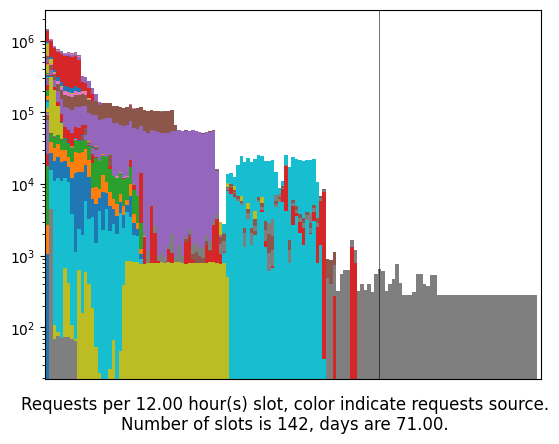

In [62]:
MAX_SLOTNUM = slot.df["slotnum"].max()
MAX_SLOTNUM_DAY = MAX_SLOTNUM / slot.SLOTS_PER_DAY
th_slotnum = int(MAX_SLOTNUM / 2) + 25

txt = f"Requests per {slot.HOUR_PER_SLOT:.2f} hour(s) slot, color indicate requests source.\nNumber of slots is {MAX_SLOTNUM}, days are {MAX_SLOTNUM_DAY:.2f}."
tmp = slot.groupsum([ "q", "pcap_id"], ["pcap_id"], days=-1)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel("")
ax.axvline(th_slotnum, color="black", linewidth=0.4)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

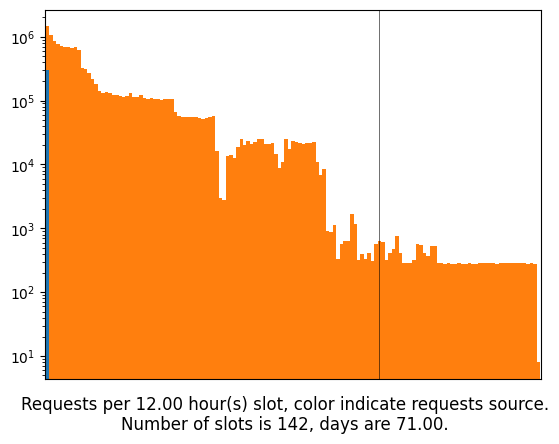

In [61]:
MAX_SLOTNUM = slot.df["slotnum"].max()
MAX_SLOTNUM_DAY = MAX_SLOTNUM / slot.SLOTS_PER_DAY
th_slotnum = int(MAX_SLOTNUM / 2) + 25

txt = f"Requests per {slot.HOUR_PER_SLOT:.2f} hour(s) slot, color indicate requests source.\nNumber of slots is {MAX_SLOTNUM}, days are {MAX_SLOTNUM_DAY:.2f}."
tmp = slot.groupsum([ "q", "dga"], ["dga"], days=-1)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel("")
ax.axvline(th_slotnum, color="black", linewidth=0.4)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

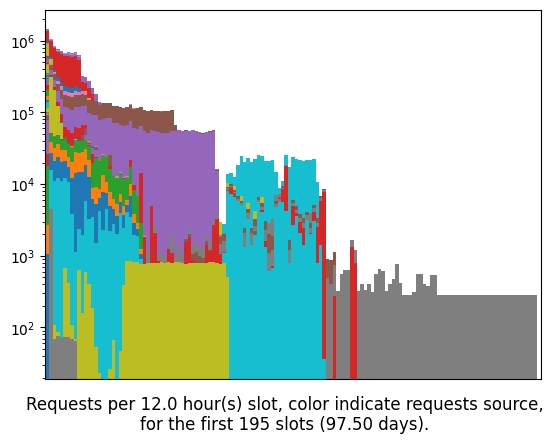

In [60]:
th_days = int(th_slotnum / slot.SLOTS_PER_DAY)

txt = f"Requests per {slot.HOUR_PER_SLOT} hour(s) slot, color indicate requests source,\nfor the first {th_slotnum} slots ({th_slotnum / slot.SLOTS_PER_DAY:.2f} days)."

tmp = slot.groupsum([ "q", "pcap_id"], ["pcap_id"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel("")
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

Axes(0.125,0.11;0.352273x0.77)


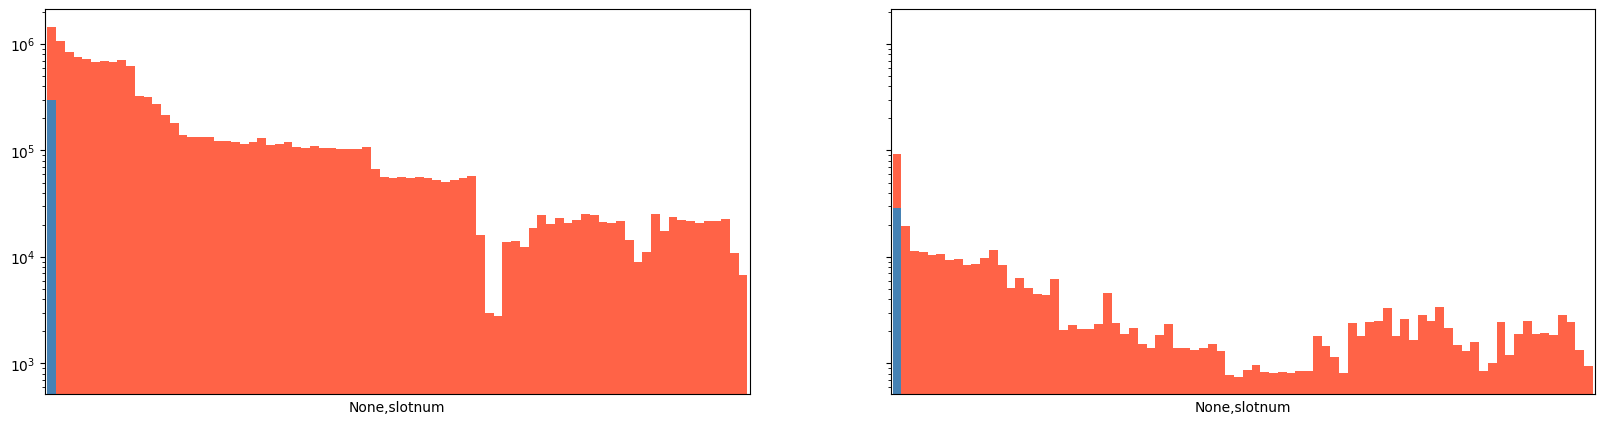

In [59]:

fig, axsp = plt.subplots(1, 2,sharey=True,)

fig.set_figwidth(20)
fig.set_figheight(5)
print(axsp[0])

txt = f"Number of requests per slot, color indicates if the source is infected or not."
tmp = slot.groupsum([ "q", "dga"], ["dga"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False, color=[ "steelblue", "tomato" ], ax=axsp[0])
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

txt = f"Number of unique domains per slot, color indicates if the source is infected or not."
tmp = slot.groupsum([ "u", "dga"], ["dga"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False, color=[ "steelblue", "tomato" ], ax=axsp[1])
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

axsp[0].set_xticks([])
axsp[1].set_xticks([])

plt.show()

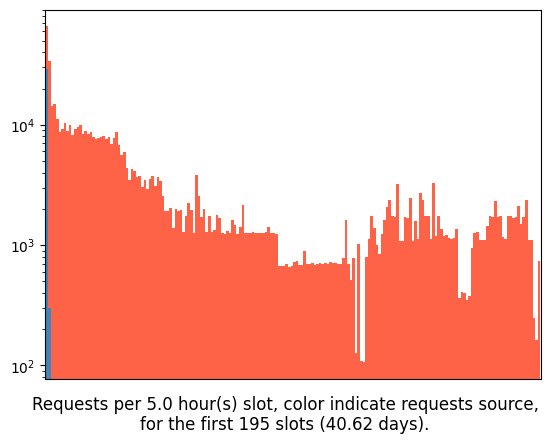

In [23]:


plt.show()

In [ ]:
th_days = int(th_slotnum / slot.SLOTS_PER_DAY)

txt = f"Requests per {slot.HOUR_PER_SLOT} hour(s) slot, color indicate requests source,\nfor the first {th_slotnum} slots ({th_slotnum / slot.SLOTS_PER_DAY:.2f} days)."

tmp = slot.groupsum([ "u", "dga"], ["dga"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False, color=[ "steelblue", "tomato" ])
ax.set_xticks([])
ax.set_xlabel("")
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

# First 5 days

## Windows over time

The number of windows active for a slot of time, which is 3600 seconds.

The last window timestamp is: 1493733000.0 (17288 days).

The last window timestamp _normalized_ is: 431998.951 (4 days).

Then, whit the slot value equal to 0. days, the maximum number of slot is 119.

This huge number is misplacing, since the:
- 163090 windows (the 99%) are within the first 117.0 slots.
- 1155 windows (the 1%) are within the last 2.0 slots.

> We decide to ignore the last 103893 windows, corresponding to the last 89.0 slots.

#### Pitfall **Spurius Correlations** for *window\_time\_start*:

> It's obvious that time start/end should not be used.

This plot demonstrate that using the _window\_time\_start/end_ feature would establish a correlation with the DGA class, since just DGA windows starts after the first slot.

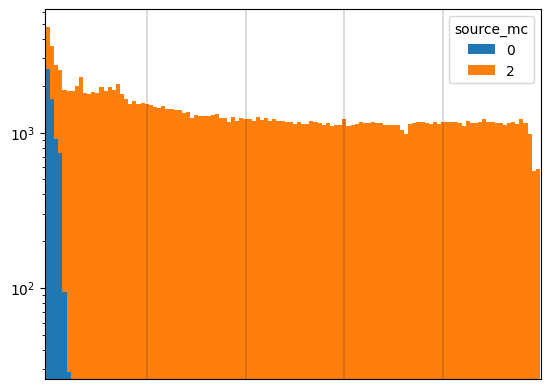

# The window distribution over sources

We can see that there are 

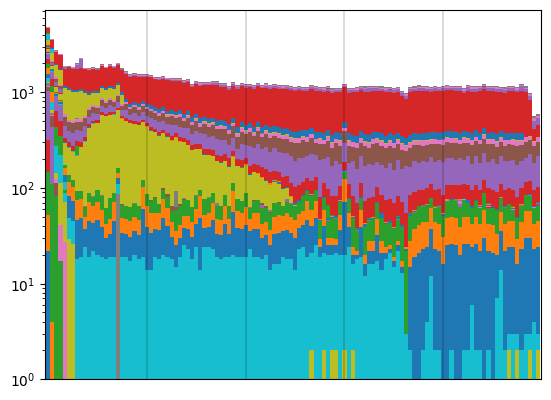

# Positives with threshold 0.5

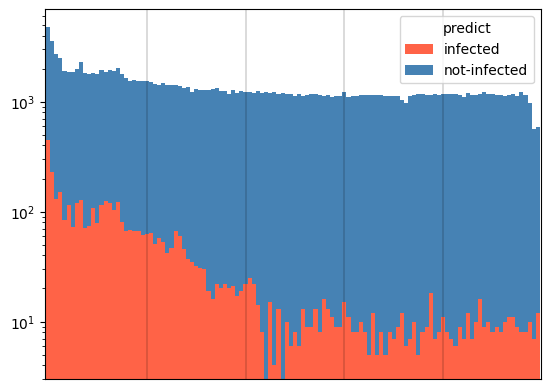

In [106]:
SEC_PER_SLOT = 1 * 60 * 60
DAY_SEC = 24 * 60 * 60
N_DAYS = 5
SLOT_PER_DAY = DAY_SEC / SEC_PER_SLOT

df = dataset.df.copy().sort_values("time_s_end_norm")
df = df[df["time_s_end_norm"] < N_DAYS * DAY_SEC]
n_slot_max = math.floor(df["time_s_end_norm"].max() / SEC_PER_SLOT)
df["slot_end"] =  np.floor(df["time_s_end_norm"] / SEC_PER_SLOT)

display(Markdown("# First %s days" % N_DAYS))

display(Markdown("## Windows over time"))
display(Markdown("The number of windows active for a slot of time, which is %s seconds." % SEC_PER_SLOT))


display(Markdown("The last window timestamp is: %s (%s days)." %(df["time_s_end"].max(), math.floor(df["time_s_end"].max() / DAY_SEC))))
display(Markdown("The last window timestamp _normalized_ is: %s (%s days)." % (df["time_s_end_norm"].max(), math.floor(df["time_s_end_norm"].max() / DAY_SEC))))



desc = df["slot_end"].describe(percentiles=[0.95, 0.99, 0.999])

display(Markdown("Then, whit the slot value equal to %.2s days, the maximum number of slot is %s." % (SEC_PER_SLOT / DAY_SEC, n_slot_max)))
display(Markdown("""This huge number is misplacing, since the:
- %s windows (the 99%%) are within the first %s slots.
- %s windows (the 1%%) are within the last %s slots.""" % ((df["slot_end"] <= desc.loc['99%']).sum(), desc.loc['99%'], (df["slot_end"] > desc.loc['99%']).sum(), df["slot_end"].max() - desc.loc['99%'])))


n_slot_th = 30

display(Markdown("> We decide to ignore the last %s windows, corresponding to the last %s slots." % ((df["slot_end"] > n_slot_th).sum(), df["slot_end"].max() - n_slot_th)))




display(Markdown("#### Pitfall **Spurius Correlations** for *window\\_time\\_start*:"))

display(Markdown("> It's obvious that time start/end should not be used."))

display(Markdown("This plot demonstrate that using the _window\\_time\\_start/end_ feature would establish a correlation with the DGA class, since just DGA windows starts after the first slot."))

tmp = df[["source_mc", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
ax.set_xticks([])
ax.set_xlabel(None)
plt.show()



display(Markdown("# The window distribution over sources"))
display(Markdown("We can see that there are "))
tmp = df[["source_id", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
    # ax.text(day * DAY_SEC / SLOT_SEC + 0.1, 0,  'blah', rotation=90)
plt.show()



display(Markdown("# Positives with threshold 0.5"))
df["predict"] = "infected"
df["predict"] = df["predict"].where(df["eps_NONE_0.500"] > 0.5, "not-infected")
tmp = df[["predict", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=True, color=[ "tomato", "steelblue"])
ax.set_xticks([])
ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
plt.show()


### Using threshold 0.5

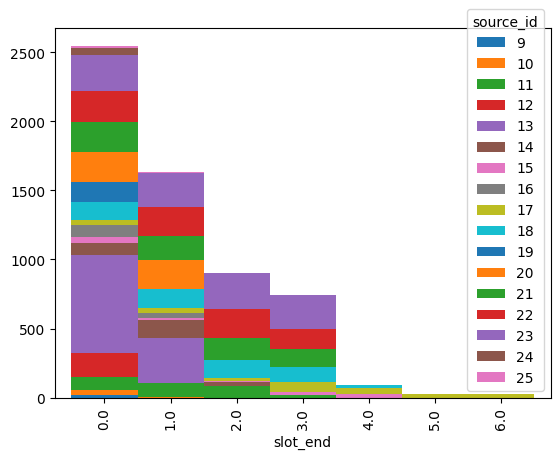

### Using threshold 0.5

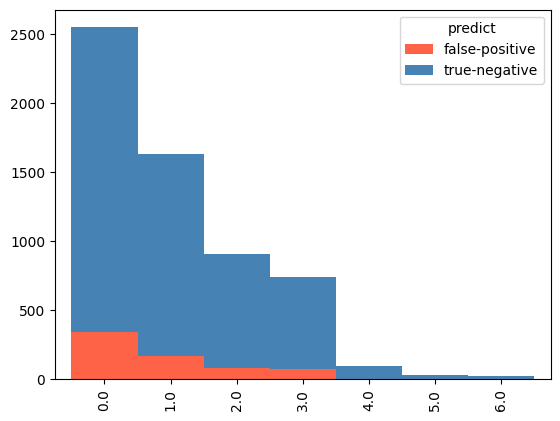

In [11]:
SEC_PER_SLOT = 1 * 60 * 60
DAY_SEC = 24 * 60 * 60
N_DAYS = 1
SLOT_PER_DAY = DAY_SEC / SEC_PER_SLOT

df = dataset.df.copy().sort_values("time_s_end_norm")
df = df[df["source_mc"] == 0]
df["slot_end"] =  np.floor(df["time_s_end_norm"] / SEC_PER_SLOT)

display(Markdown("### Using threshold 0.5"))



tmp = df[["source_id", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=False, legend=True)
plt.show()

display(Markdown("### Using threshold 0.5"))

df["predict"] = "false-positive"
df["predict"] = df["predict"].where(df["eps_NONE_0.500"] > 0.5, "true-negative")

tmp = df[["predict", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=False, legend=True, color=[ "tomato", "steelblue"])
# ax.set_xticks([])

ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
plt.show()

1493733000.0 17288
count    267095.000000
mean         86.356296
std        1171.467916
min           0.000000
50%           3.000000
95%          24.000000
99%          38.000000
max       17288.000000
Name: w_plot_end, dtype: float64


<Axes: >

1493733000.0 17288
17288


KeyboardInterrupt: 

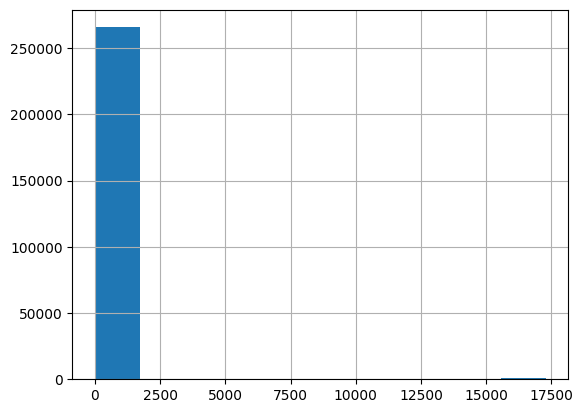

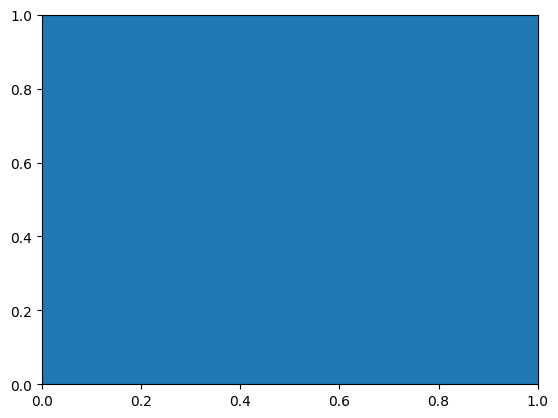

In [156]:
w_sec = 24 * 60 * 60
df = dataset.df.copy().sort_values("time_s_end")

df = df#.iloc[0:1000]

n_windows_max = math.floor(df["time_s_end"].max() / w_sec)
print(df["time_s_end"].max(), n_windows_max)

# df = df[df["time_s_end"] < w_sec * 200]

df["w_plot_end"] =  np.floor(df["time_s_end"] / w_sec)

print(df["w_plot_end"].describe(percentiles=[0.95, 0.99]))

display(df["w_plot_end"].hist())

n_windows = math.floor(df["time_s_end"].max() / w_sec)

print(df["time_s_end"].max(), n_windows)

bins = np.zeros((n_windows, 2))
print(math.floor(df["time_s_end"].max() / w_sec))
for row, window in df.iterrows():
    bin_start = math.floor(window["time_s_start"] / w_sec) # type: ignore
    bin_end = math.floor(window["time_s_end"] / w_sec) # type: ignore

    bins[bin_start:bin_end, 0] += 1
    bins[bin_start:bin_end, 1] += 1 if window["eps_NONE_0.500"] > 0 else 0
    pass

dftmp = pd.DataFrame(bins, columns=["nw", "p"])
dftmp["nw"] -= dftmp["p"]
dftmp.plot.bar(stacked=True, width=1)#log=False, sharex=True, stacked=True, histtype="step")

array([[<Axes: title={'center': 'n'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

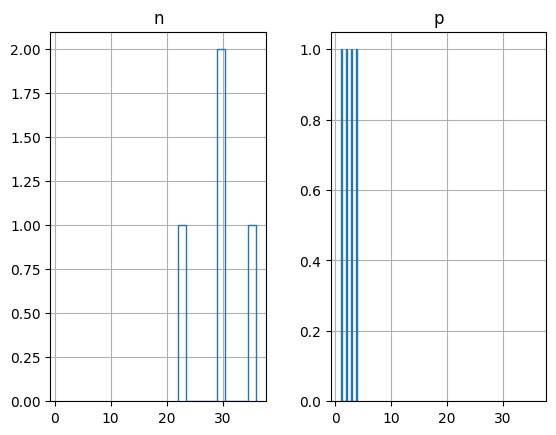

In [ ]:
df = dataset.df[dataset.df[("source_mc")] == 0].copy()
df.time_s_start = df.time_s_start.astype(int)

# df.xs('-', level=0, axis=1).xs('-', level=0, axis=1)

first_time_s_start = df[["source_id", "time_s_start"]]
first_time_s_start = first_time_s_start.groupby("source_id").min().reset_index()
first_time_s_start = first_time_s_start.rename(columns={ "time_s_start": "first_time_s_start" })

first_time_s_start = df.merge(first_time_s_start, suffixes=["", ""], left_on=["source_id"], right_on=["source_id"], validate="many_to_one")#[("-", "-", "first_time_s_start")]

display(first_time_s_start[[ "time_s_start", "first_time_s_start"]])
display(first_time_s_start["time_s_start"] - first_time_s_start["first_time_s_start"])

# df["-", "-", "common_start_time_s"] = df["-", "-", "time_s_start"] - first_time_s_start

# df.sort_values(by=[("-", "source", "id"), ("-", "-", "index")], ascending=False)

,time_s_start,first_time_s_start
0,1387314600,1387314600
1,1387314800,1387314600
2,1387315000,1387314600
3,1387315000,1387314600
4,1387315000,1387314600
...,...,...
5974,1493732900,1493727700
5975,1493732900,1493727700
5976,1493732900,1493727700
5977,1493732900,1493727700


0          0
1        200
2        400
3        400
4        400
        ... 
5974    5200
5975    5200
5976    5200
5977    5200
5978    5200
Length: 5979, dtype: int64

In [ ]:

# df_normal_approach.reset_index(level=[1,2], names=['nn'])

# df_normal_approach.reset_index(level=[1,2], names=['nn', 'th']).groupby(['nn', 'th']).mean()
tmp = df_normal_approach.reset_index(level=[1,2], names=['id','nn','th'])

# tmp.groupby(['nn', 'th']).describe().round(2).drop(['q', 'u'], level=0, axis=1)
tmp.groupby(['nn', 'th']).describe().round(2).xs('fp', level=0, axis=1)


NameError: name 'df_normal_approach' is not defined

In [ ]:
from IPython.display import display, Markdown, Latex

display(Markdown("# fp_rate_min"))

display(tmp.groupby(['nn', 'th']).describe().round(2).xs('fp_rate_min', level=0, axis=1))

# fp_rate_min

count  mean   std   min   25%   50%   75%    max
nn      th                                                     
ICANN   0.100   17.0  1.78  2.48  0.00  0.34  0.70  1.54   7.73
        0.250   17.0  1.45  2.10  0.00  0.09  0.55  1.24   6.46
        0.500   17.0  1.17  1.69  0.00  0.07  0.46  1.07   5.24
        0.900   17.0  0.87  1.33  0.00  0.03  0.34  0.70   4.12
NONE    0.100   17.0  2.38  2.83  0.05  0.37  1.66  3.46  11.40
        0.250   17.0  2.19  2.58  0.05  0.35  1.52  3.04  10.31
        0.500   17.0  1.87  2.07  0.00  0.29  1.39  2.64   8.23
        0.900   17.0  1.45  1.60  0.00  0.17  1.17  1.80   6.34
PRIVATE 0.100   17.0  3.66  4.08  0.05  0.76  2.44  4.72  15.88
        0.250   17.0  2.98  2.99  0.05  0.64  2.17  4.21  11.76
        0.500   17.0  2.55  2.53  0.05  0.44  1.97  3.76   9.77
        0.900   17.0  1.80  1.67  0.00  0.26  1.62  2.87   5.89
TLD     0.100   17.0  0.85  1.33  0.00  0.21  0.30  0.74   5.05
        0.250   17.0  0.72  1.24  0.00  0.17  0.25  0.58   4.67
        0.500   17.0  0.64  1.11  0.00  0.10  0.23  0.50   4.24
        0.900   17.0  0.60  1.04  0.00  0.10  0.20  0.47   4.03

In [ ]:
from IPython.display import display, Markdown, Latex

display(Markdown("# u_fp_rate_min"))

display(tmp.groupby(['nn', 'th']).describe().round(2).xs('u_fp_rate_min', level=0, axis=1))

# u_fp_rate_min

count  mean   std   min   25%   50%   75%   max
nn      th                                                    
ICANN   0.100   17.0  0.81  1.13  0.00  0.09  0.36  0.66  3.57
        0.250   17.0  0.66  0.95  0.00  0.07  0.30  0.53  2.98
        0.500   17.0  0.53  0.77  0.00  0.06  0.23  0.45  2.32
        0.900   17.0  0.40  0.60  0.00  0.02  0.16  0.30  1.80
NONE    0.100   17.0  1.06  1.31  0.03  0.17  0.68  1.47  5.27
        0.250   17.0  0.98  1.19  0.03  0.17  0.62  1.29  4.76
        0.500   17.0  0.83  0.96  0.00  0.16  0.57  1.12  3.80
        0.900   17.0  0.64  0.74  0.00  0.13  0.48  0.84  2.93
PRIVATE 0.100   17.0  1.64  1.89  0.05  0.44  1.00  2.04  7.34
        0.250   17.0  1.33  1.38  0.05  0.39  0.89  1.82  5.43
        0.500   17.0  1.13  1.17  0.05  0.20  0.80  1.62  4.51
        0.900   17.0  0.79  0.77  0.00  0.08  0.66  1.24  2.72
TLD     0.100   17.0  0.38  0.62  0.00  0.08  0.15  0.32  2.33
        0.250   17.0  0.33  0.58  0.00  0.06  0.10  0.25  2.16
        0.500   17.0  0.29  0.51  0.00  0.06  0.09  0.22  1.96
        0.900   17.0  0.27  0.48  0.00  0.04  0.09  0.20  1.86

In [ ]:
from IPython.display import display, Markdown, Latex

display(Markdown("# u_fp_rate_min"))

display(tmp.groupby(['nn', 'th']).describe().round(2).xs('u_fp_rate_min', level=0, axis=1))

In [ ]:
from IPython.display import display, Markdown, Latex

df_na_th = df_normal_approach.reset_index(level=[1,2], names=['id','nn','th'])

ei = df_na_th[df_na_th['th'] == '0.100']["fp"].sort_values()
print( ei.iloc[int(ei.shape[0] * 0.25)] / 2+ ei.iloc[int(ei.shape[0] * 0.25)-1] / 2)

display(Markdown("# Grouping by sources and NN"))
display(Markdown("## FP"))
display(df_na_th.groupby(['th']).describe().round(2).xs('fp', level=0, axis=1))
display(Markdown("## fp_rate_min"))
display(df_na_th.groupby(['th']).describe().round(2).xs('fp_rate_min', level=0, axis=1))
display(Markdown("## u_fp_rate_min"))
display(df_na_th.groupby(['th']).describe().round(2).xs('u_fp_rate_min', level=0, axis=1))

31.5


# Grouping by sources and NN

## FP

,count,mean,std,min,25%,50%,75%,max
th,,,,,,,,
0.100,68.0,233.88,327.62,0.0,32.75,91.5,268.25,1496.0
0.250,68.0,201.43,283.32,0.0,23.50,76.5,229.00,1288.0
0.500,68.0,174.76,248.25,0.0,20.25,60.0,204.25,1159.0
0.900,68.0,135.93,195.48,0.0,13.50,48.5,148.00,968.0


## fp_rate_min

,count,mean,std,min,25%,50%,75%,max
th,,,,,,,,
0.100,68.0,2.17,2.97,0.0,0.29,0.81,3.25,15.88
0.250,68.0,1.84,2.42,0.0,0.22,0.65,2.88,11.76
0.500,68.0,1.56,2.02,0.0,0.21,0.55,2.57,9.77
0.900,68.0,1.18,1.48,0.0,0.15,0.45,1.90,6.34


## u_fp_rate_min

,count,mean,std,min,25%,50%,75%,max
th,,,,,,,,
0.100,68.0,0.97,1.37,0.0,0.11,0.38,1.43,7.34
0.250,68.0,0.82,1.11,0.0,0.10,0.30,1.25,5.43
0.500,68.0,0.70,0.92,0.0,0.09,0.24,1.12,4.51
0.900,68.0,0.53,0.67,0.0,0.07,0.17,0.86,2.93
